In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, RandomTranslation, RandomZoom)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.keras.utils import plot_model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,

    "DROPOUT_RATE_B1": 0.2,#0.0
    "DROPOUT_RATE_B2": 0.3,#0.0
    "DROPOUT_RATE_B3": 0.4,#0.0
    "DROPOUT_RATE_B4": 0.5,#0.0

    "REGULARIZATION_RATE":  1e-3,#0.0
    "N_FILTERS_B1": 32,#6
    "N_FILTERS_B2": 64,#6
    "N_FILTERS_B3": 128,#6

    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 256,#1024
    "N_DENSE_2": 128,
    "NUM_CLASSES": 15,#21
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES":["Pepper__bell___Bacterial_spot", "Pepper__bell___healthy",
                   "Potato___Early_blight","Potato___healthy","Potato___Late_blight",
                   "Tomato__Target_Spot","Tomato__Tomato_mosaic_virus","Tomato__Tomato_YellowLeaf__Curl_Virus","Tomato_Bacterial_spot",
                   "Tomato_Early_blight","Tomato_healthy","Tomato_Late_blight",
                    "Tomato_Leaf_Mold","Tomato_Septoria_leaf_spot","Tomato_Spider_mites_Two_spotted_spider_mite"],
}

In [4]:
train_directory = "/content/drive/MyDrive/PlantVillage_ver1/train"
val_directory = "/content/drive/MyDrive/PlantVillage_ver1/val"
test_directory = "/content/drive/MyDrive/PlantVillage_ver1/test"

# Data Management

/tmp/ipython-input-5-2226236265.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")
/tmp/ipython-input-5-2226236265.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


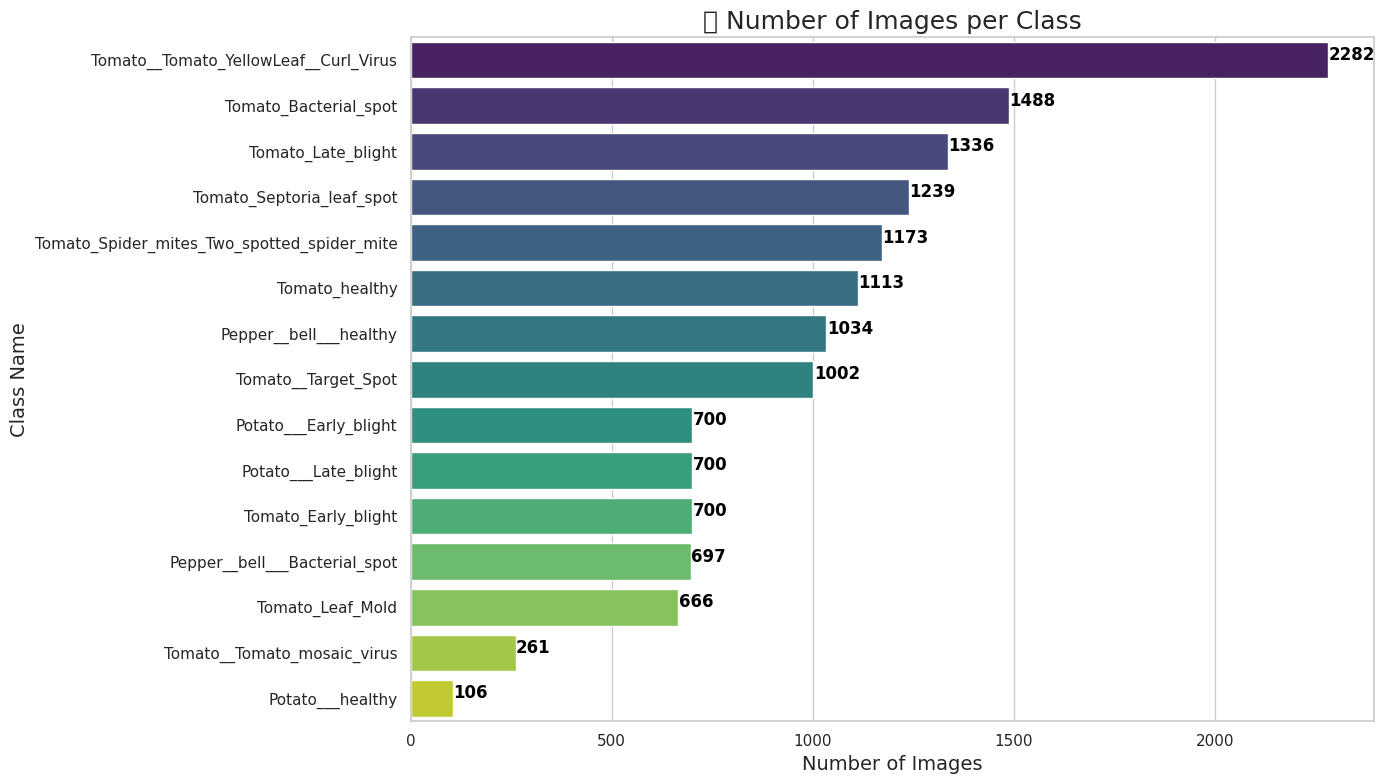

In [5]:
# Set your path
data_dir = "/content/drive/MyDrive/PlantVillage_ver1/train"  # Change to your training folder

# Count images per class
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = count

# Sort by count (optional)
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
ax = sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")

# Add counts to bars
for i, v in enumerate(class_counts.values()):
    ax.text(v + 1, i, str(v), color='black', fontweight='bold')

plt.title("📊 Number of Images per Class", fontsize=18)
plt.xlabel("Number of Images", fontsize=14)
plt.ylabel("Class Name", fontsize=14)
plt.tight_layout()
plt.show()


/tmp/ipython-input-6-1033428294.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


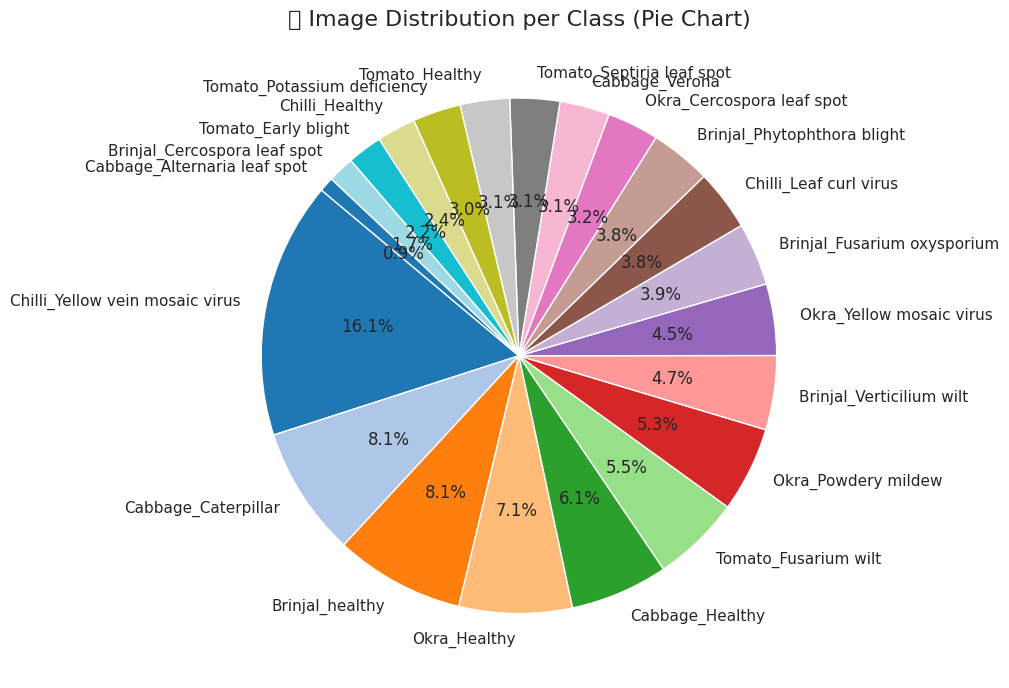

In [6]:
# === CONFIG ===
data_dir = "/content/drive/MyDrive/ICVDD/ICVDD_Ver2/train"  # Change to your train directory

# === Collect class counts ===
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[class_name] = count

# Sort by count (optional)
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

# === PIE CHART ===
def plot_pie_chart(class_counts):
    plt.figure(figsize=(10, 10))
    plt.pie(
        class_counts.values(),
        labels=class_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.tab20.colors
    )
    plt.title("📊 Image Distribution per Class (Pie Chart)", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_pie_chart(class_counts)



/tmp/ipython-input-7-3361388549.py:32: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


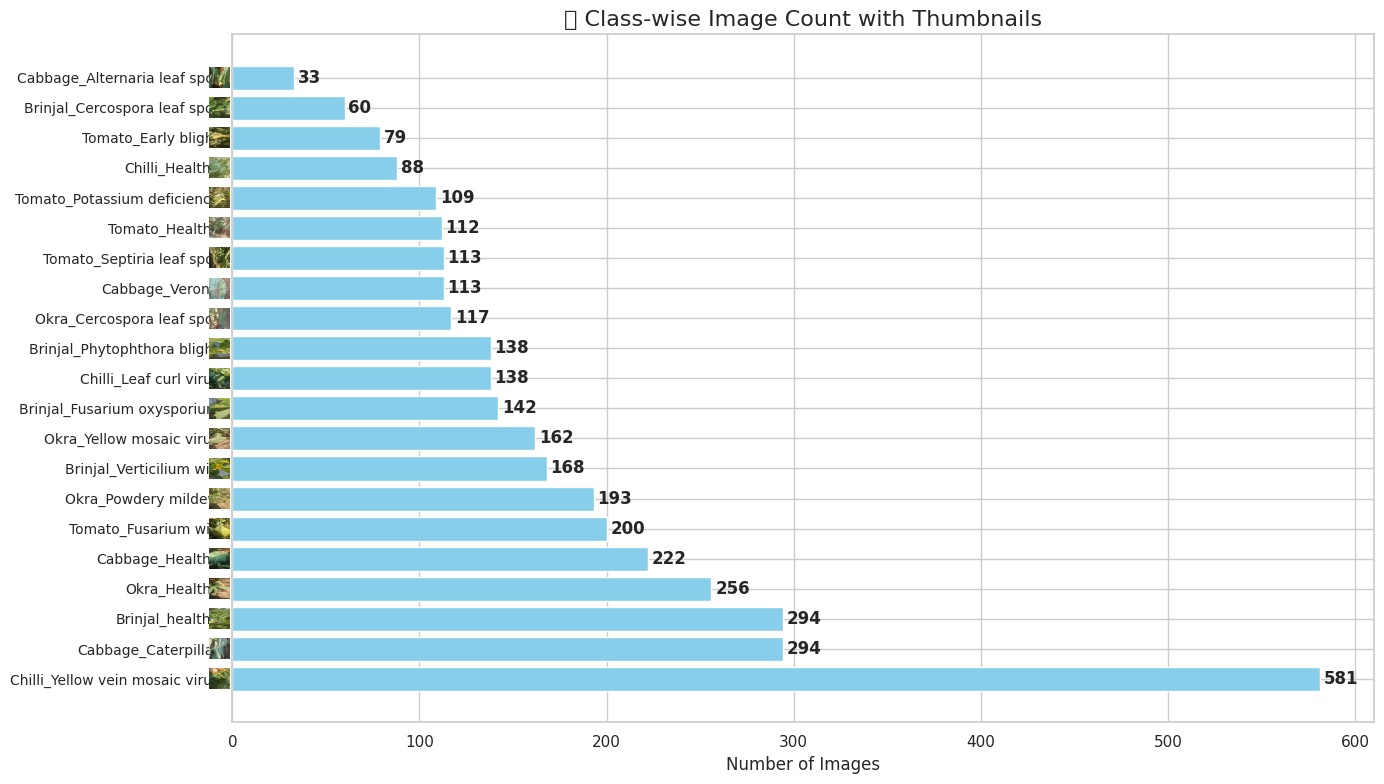

In [7]:
def get_thumbnail(path, size=(30, 30)):
    try:
        for f in os.listdir(path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(path, f)
                return Image.open(img_path).resize(size)
    except:
        return None

def plot_bar_with_thumbnails(class_counts, base_dir):
    fig, ax = plt.subplots(figsize=(14, 8))
    y_pos = np.arange(len(class_counts))
    bar = ax.barh(y_pos, class_counts.values(), color='skyblue')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(class_counts.keys(), fontsize=10)
    ax.set_xlabel("Number of Images", fontsize=12)
    ax.set_title("🖼️ Class-wise Image Count with Thumbnails", fontsize=16)

    # Add image thumbnails
    for i, class_name in enumerate(class_counts.keys()):
        thumb_path = os.path.join(base_dir, class_name)
        img = get_thumbnail(thumb_path)
        if img:
            imagebox = OffsetImage(img, zoom=0.5)
            ab = AnnotationBbox(imagebox, (0, i), frameon=False, box_alignment=(1.1, 0.5))
            ax.add_artist(ab)

    for i, v in enumerate(class_counts.values()):
        ax.text(v + 2, i, str(v), va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_bar_with_thumbnails(class_counts, data_dir)


/tmp/ipython-input-8-1087344981.py:28: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


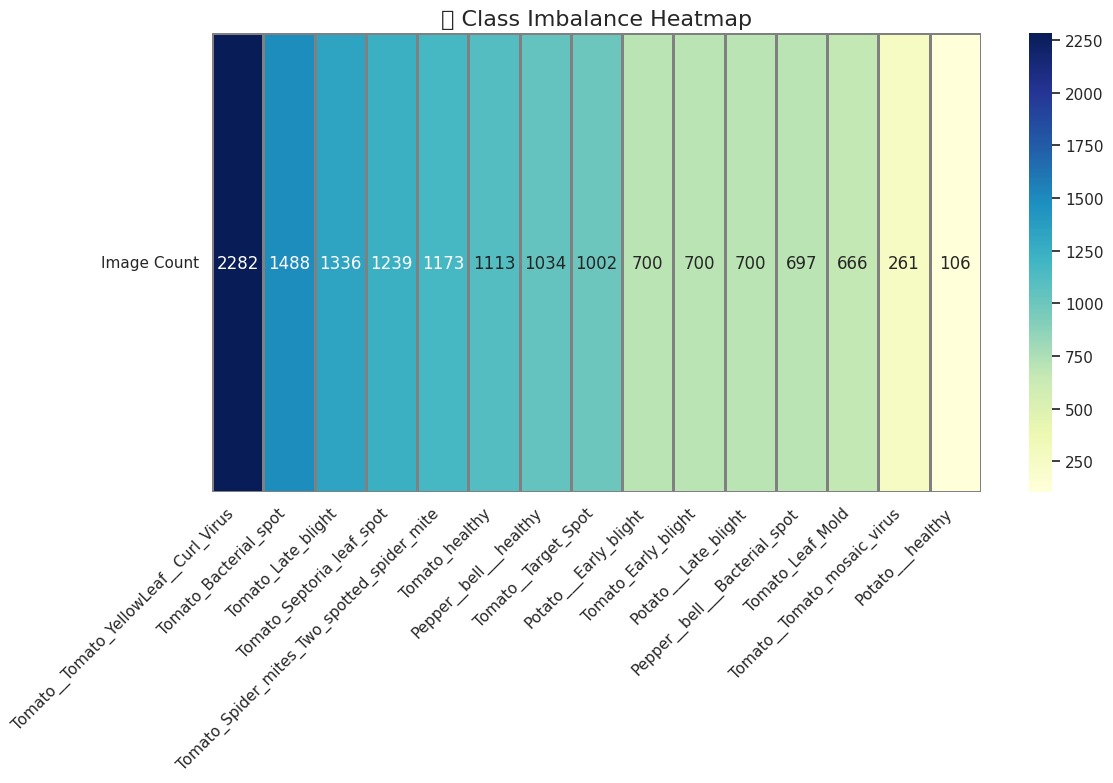

In [8]:

import pandas as pd

# === CONFIG ===
data_dir = "/content/drive/MyDrive/PlantVillage_ver1/train"  # Path to your training data

# === Collect class counts ===
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[class_name] = count

# === Convert to DataFrame ===
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
df_counts = df_counts.sort_values('Image Count', ascending=False)

# === Create Heatmap ===
plt.figure(figsize=(12, 8))
sns.heatmap(df_counts.T, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=1, linecolor='gray')

plt.title("🔥 Class Imbalance Heatmap", fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Dataset Loading

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 14497 files belonging to 15 classes.


In [10]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 3151 files belonging to 15 classes.


In [11]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 3111 files belonging to 15 classes.


In [69]:
# Extract true labels
y_test = np.concatenate([labels.numpy() for _, labels in test_dataset])

In [ ]:
# for i in val_dataset.take(1):
#   print(i)

#Data Augmentation

In [12]:
def visulize(original,augmented):
  normalized_original = original / 255.0
  augmented_original = augmented / 255.0
  #fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(normalized_original[0])

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented_original[0])

In [13]:
original_image, label = next(iter(train_dataset))

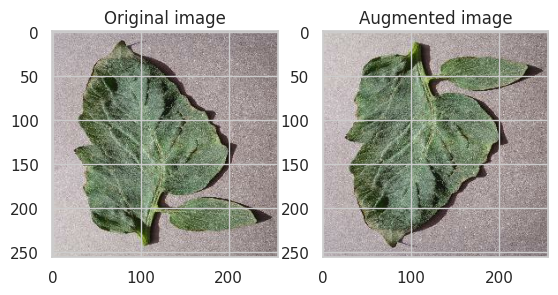

In [14]:
augmented_image= tf.image.flip_up_down(original_image)
visulize(original_image,augmented_image)

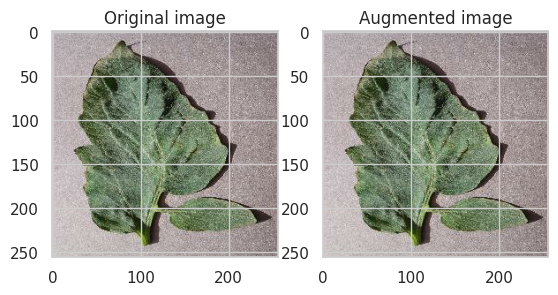

In [15]:
augmented_image= tf.image.adjust_brightness(original_image,delta=0.2)
visulize(original_image,augmented_image)

## Dataset Visualization

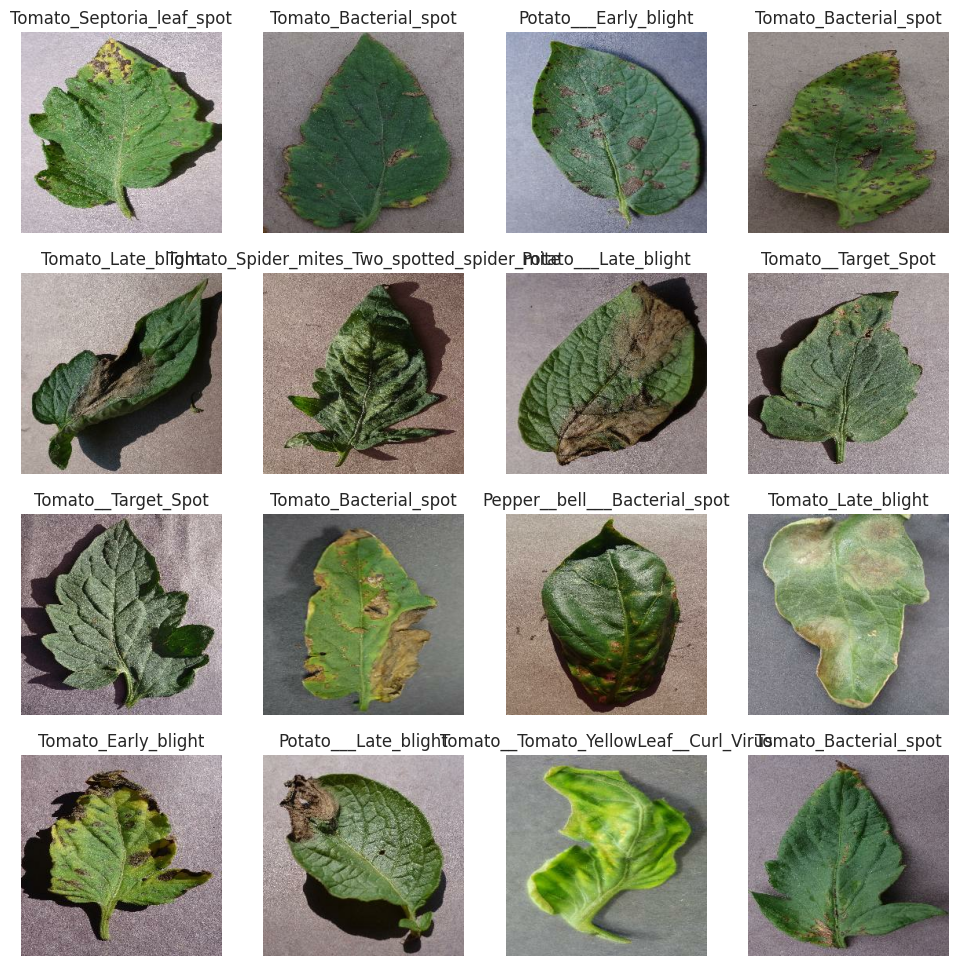

In [16]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## Data Augmentation

In [17]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [18]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

### Cutmix Augmentation

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Dataset Preparation

In [ ]:
 #train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
 #train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

 #mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:

 #training_dataset = (
 #    mixed_dataset
 #    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
 #    .prefetch(tf.data.AUTOTUNE)
# )

In [19]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [21]:
validation_dataset = (
    val_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [20]:
testing_dataset = (
    test_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [23]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [24]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

# Modeling

## Lenet

In [25]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,
    #Block 1
    Conv2D(filters = CONFIGURATION["N_FILTERS_B1"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE_B1"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS_B1"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),


    #Block 2
    Conv2D(filters = CONFIGURATION["N_FILTERS_B2"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE_B2"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS_B2"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    #Block 3
    Conv2D(filters = CONFIGURATION["N_FILTERS_B3"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE_B3"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS_B3"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),


    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE_B4"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 68)   │        19,652 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 68)   │           272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 68)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        39,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 132)    │        76,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 132)    │           528 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 132)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │       152,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 260)      │       299,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 260)      │         1,040 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 260)      │             

 Total params: 893,515 (3.41 MB)

 Trainable params: 891,379 (3.40 MB)

 Non-trainable params: 2,136 (8.34 KB)

In [28]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [30]:
#metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall
metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=2, name="top_k_accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
    #F1Score(name="f1_score")
]

In [31]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [32]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 1636s 4s/step - accuracy: 0.4927 - loss: 2.7559 - precision: 0.6687 - recall: 0.3509 - top_k_accuracy: 0.6468 - val_accuracy: 0.2056 - val_loss: 6.3828 - val_precision: 0.2154 - val_recall: 0.1895 - val_top_k_accuracy: 0.2980
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - accuracy: 0.7425 - loss: 1.7803 - precision: 0.8173 - recall: 0.6611 - top_k_accuracy: 0.8867 - val_accuracy: 0.5281 - val_loss: 2.6305 - val_precision: 0.5985 - val_recall: 0.4694 - val_top_k_accuracy: 0.6903
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.8043 - loss: 1.4619 - precision: 0.8568 - recall: 0.7526 - top_k_accuracy: 0.9244 - val_accuracy: 0.7953 - val_loss: 1.3649 - val_precision: 0.8432 - val_recall: 0.7540 - val_top_k_accuracy: 0.9292
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - accuracy: 0.8386 - loss: 1.2302 - precision: 0.8783 - recall: 0.7990 - top_k_accuracy: 0.9438 - val_accuracy: 0.6639 - val_loss: 1.6772 - val_p

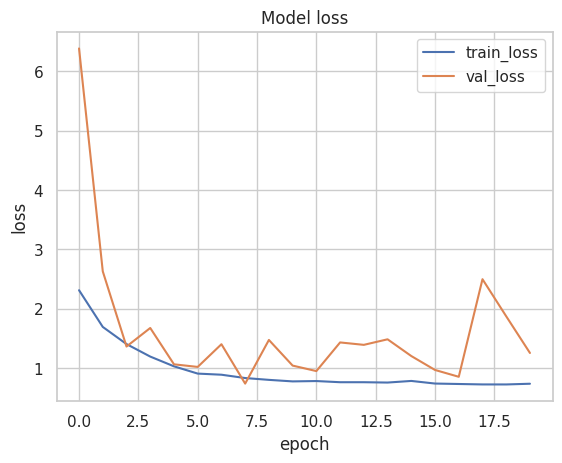

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

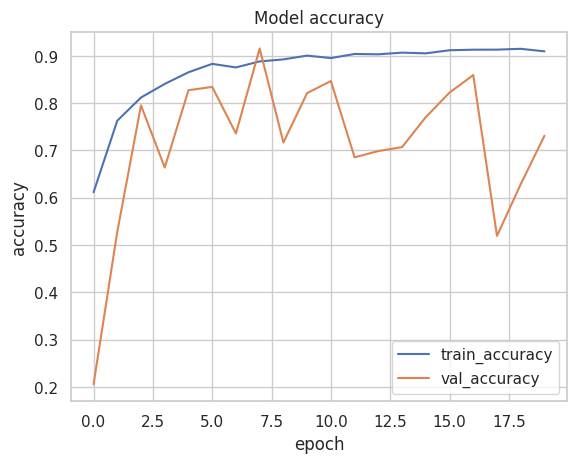

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Complete Network

## Transfer Learning with EfficientNet

In [35]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [36]:
backbone.trainable = False

In [37]:
efficientnet_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
efficientnet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,168,686 (69.31 MB)

 Trainable params: 494,351 (1.89 MB)

 Non-trainable params: 17,674,335 (67.42 MB)

In [38]:
efficientnet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [39]:
history1 = efficientnet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 151s 241ms/step - accuracy: 0.7611 - loss: 0.7956 - precision: 0.8329 - recall: 0.6919 - top_k_accuracy: 0.8999 - val_accuracy: 0.8978 - val_loss: 0.3125 - val_precision: 0.9188 - val_recall: 0.8829 - val_top_k_accuracy: 0.9683
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 87s 192ms/step - accuracy: 0.9089 - loss: 0.2776 - precision: 0.9264 - recall: 0.8890 - top_k_accuracy: 0.9723 - val_accuracy: 0.9226 - val_loss: 0.2367 - val_precision: 0.9347 - val_recall: 0.9092 - val_top_k_accuracy: 0.9775
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 88s 193ms/step - accuracy: 0.9297 - loss: 0.2064 - precision: 0.9452 - recall: 0.9176 - top_k_accuracy: 0.9790 - val_accuracy: 0.9238 - val_loss: 0.2449 - val_precision: 0.9332 - val_recall: 0.9178 - val_top_k_accuracy: 0.9819
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 87s 190ms/step - accuracy: 0.9352 - loss: 0.1770 - precision: 0.9468 - recall: 0.9275 - top_k_accuracy: 0.9869 - val_accuracy: 0.9210 - val_loss: 0.2352 - val

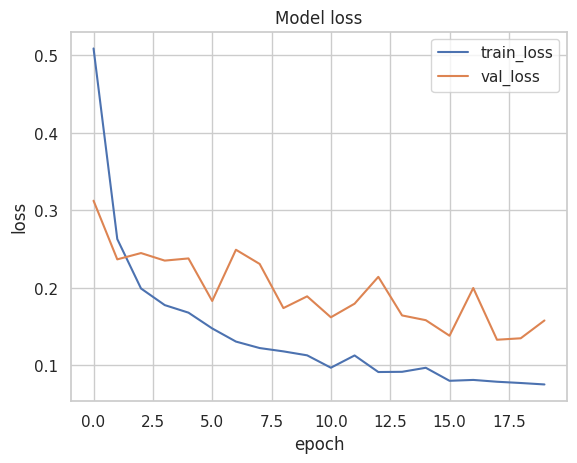

In [40]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

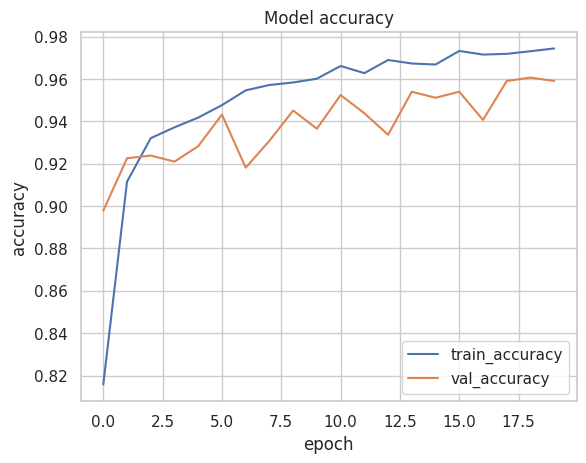

In [41]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Transfer Learning with MobileNetV2

In [42]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

/tmp/ipython-input-42-3786300760.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [43]:
backbone.trainable = False

In [44]:
mobilenet_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
mobilenet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,775 (10.00 MB)

 Trainable params: 363,279 (1.39 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [45]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [46]:
#metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall
metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=2, name="top_k_accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
    #F1Score(name="f1_score")
]

In [47]:
mobilenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [48]:
history2 = mobilenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - accuracy: 0.6167 - loss: 1.1976 - precision: 0.8098 - recall: 0.4640 - top_k_accuracy: 0.7601 - val_accuracy: 0.7045 - val_loss: 0.9256 - val_precision: 0.7880 - val_recall: 0.6312 - val_top_k_accuracy: 0.8388
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 58s 127ms/step - accuracy: 0.7986 - loss: 0.5881 - precision: 0.8595 - recall: 0.7381 - top_k_accuracy: 0.9182 - val_accuracy: 0.7467 - val_loss: 0.7701 - val_precision: 0.8108 - val_recall: 0.6963 - val_top_k_accuracy: 0.8746
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 60s 131ms/step - accuracy: 0.8282 - loss: 0.5019 - precision: 0.8746 - recall: 0.7803 - top_k_accuracy: 0.9335 - val_accuracy: 0.7778 - val_loss: 0.7067 - val_precision: 0.8245 - val_recall: 0.7394 - val_top_k_accuracy: 0.8988
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 58s 126ms/step - accuracy: 0.8532 - loss: 0.4315 - precision: 0.8896 - recall: 0.8148 - top_k_accuracy: 0.9482 - val_accuracy: 0.7737 - val_loss: 0.6867 - val_

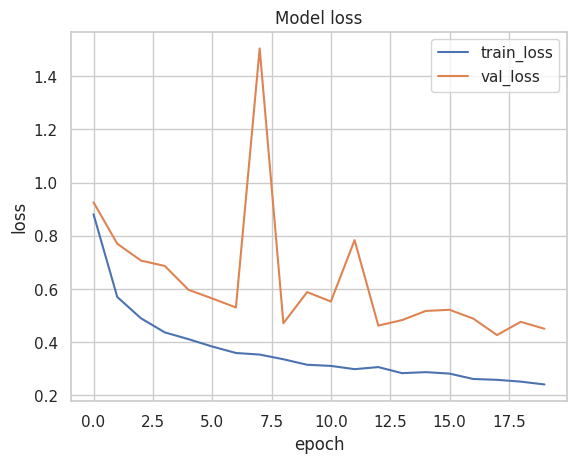

In [49]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

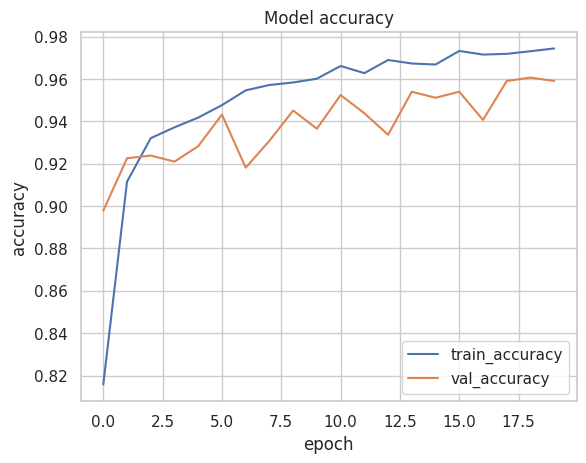

In [50]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

#Densenet

In [51]:
backbone = tf.keras.applications.densenet.DenseNet201(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [52]:
backbone.trainable = False

In [53]:
densenet_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
densenet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 8, 8, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,849,615 (71.91 MB)

 Trainable params: 527,119 (2.01 MB)

 Non-trainable params: 18,322,496 (69.89 MB)

In [54]:
densenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [55]:
history3 = densenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 202s 341ms/step - accuracy: 0.8050 - loss: 0.8720 - precision: 0.8858 - recall: 0.7343 - top_k_accuracy: 0.9044 - val_accuracy: 0.8585 - val_loss: 0.4515 - val_precision: 0.8863 - val_recall: 0.8362 - val_top_k_accuracy: 0.9426
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 120s 264ms/step - accuracy: 0.9025 - loss: 0.2972 - precision: 0.9263 - recall: 0.8761 - top_k_accuracy: 0.9719 - val_accuracy: 0.8712 - val_loss: 0.3986 - val_precision: 0.8944 - val_recall: 0.8546 - val_top_k_accuracy: 0.9565
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 121s 265ms/step - accuracy: 0.9219 - loss: 0.2360 - precision: 0.9402 - recall: 0.9048 - top_k_accuracy: 0.9784 - val_accuracy: 0.9226 - val_loss: 0.2415 - val_precision: 0.9393 - val_recall: 0.9080 - val_top_k_accuracy: 0.9778
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 120s 264ms/step - accuracy: 0.9372 - loss: 0.1885 - precision: 0.9505 - recall: 0.9236 - top_k_accuracy: 0.9858 - val_accuracy: 0.9137 - val_loss: 0.2565 - 

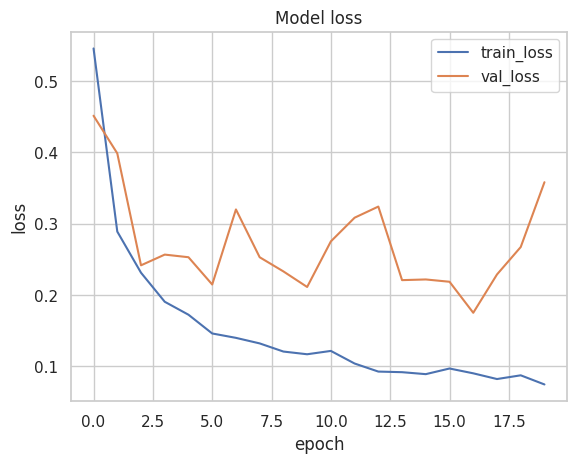

In [56]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

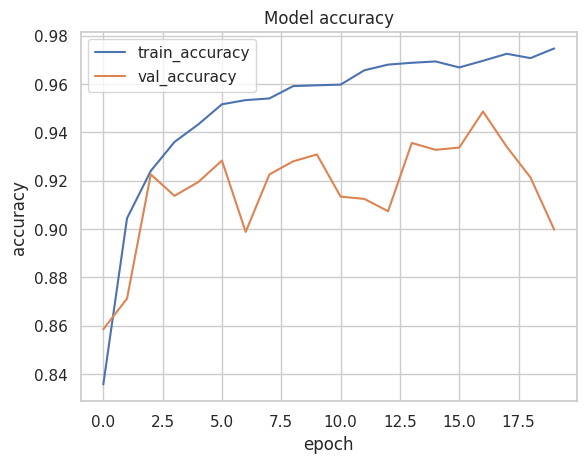

In [57]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
ensemble_model.evaluate(testing_dataset)

#ROC AUC curve

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

num_classes = 21
class_names = ["Brinjal_Cercospora leaf spot", "Brinjal_Fusarium oxysporium", "Brinjal_healthy",
                    "Brinjal_Phytophthora blight","Brinjal_Verticilium wilt","Cabbage_Alternaria leaf spot","Cabbage_Caterpillar",
                    "Cabbage_Healthy","Cabbage_Verona","Chilli_Healthy","Chilli_Leaf curl virus","Chilli_Yellow vein mosaic virus",
                    "Okra_Cercospora leaf spot","Okra_Healthy","Okra_Powdery mildew","Okra_Yellow mosaic virus",
                    "Tomato_Early blight","Tomato_Fusarium wilt","Tomato_Healthy","Tomato_Potassium deficiency","Tomato_Septiria leaf spot"] # replace with actual class names

# One-hot encode labels
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Get model predictions (probabilities)
y_score = lenet_model.predict(test_dataset)  # shape: (num_samples, 21)

793/793 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


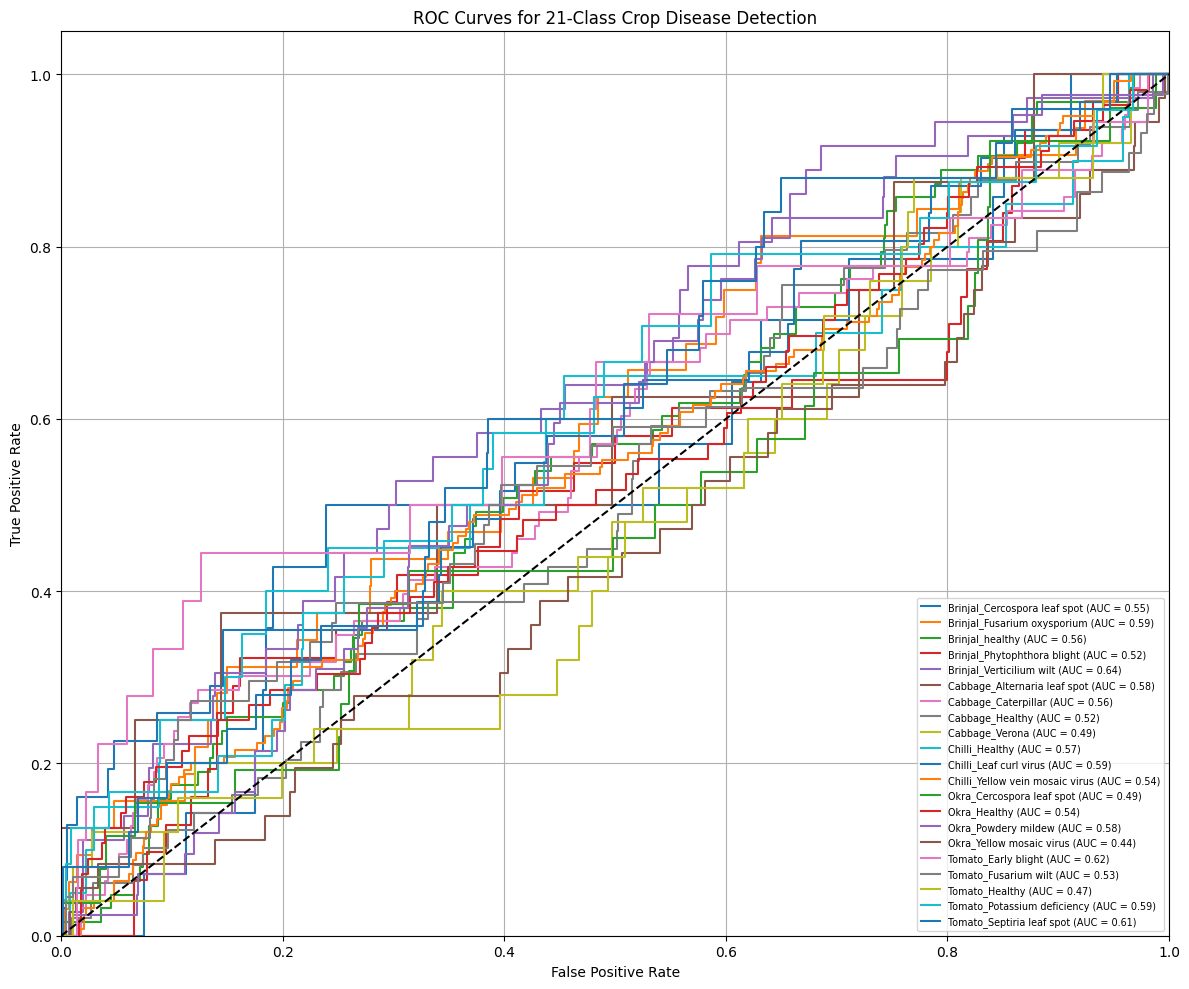

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for 21-Class Crop Disease Detection")
plt.legend(loc="lower right", fontsize="x-small")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
macro_auc = roc_auc_score(y_test_bin, y_score, average='macro')
micro_auc = roc_auc_score(y_test_bin, y_score, average='micro')

print(f"Macro-Average AUC: {macro_auc:.4f}")
print(f"Micro-Average AUC: {micro_auc:.4f}")


Macro-Average AUC: 0.5523
Micro-Average AUC: 0.5923


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

NameError: name 'history' is not defined

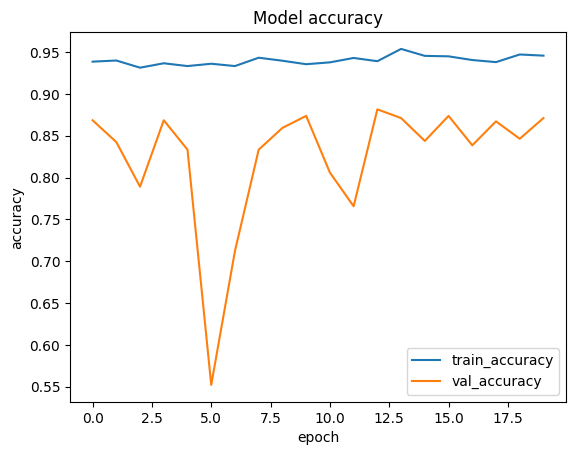

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# 2. Load the saved weights
pretrained_model.load_weights('/content/drive/MyDrive/ICVDD/efficientB0.weights.h5')

NameError: name 'pretrained_model' is not defined

In [ ]:
pretrained_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = pretrained_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = 1, #CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1989s 17s/step - accuracy: 0.9716 - loss: 0.0996 - precision: 0.9736 - recall: 0.9691 - top_k_accuracy: 0.9949 - val_accuracy: 0.9596 - val_loss: 0.1391 - val_precision: 0.9646 - val_recall: 0.9570 - val_top_k_accuracy: 0.9896


In [ ]:
# After training
pretrained_model.save("efficientB0_final.h5")

# Vision Transformer

In [58]:
pip install tensorflow tensorflow-hub

In [64]:
#import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
# === MODEL ===
class ViTClassifier(tf.keras.Model):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.resize = layers.Resizing(224, 224)
        self.rescale = layers.Rescaling(1./255)
        self.vit = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=True)
        self.dense1 = layers.Dense(256, activation='relu')
        self.dropout = layers.Dropout(0.3)
        self.out = layers.Dense(15, activation='softmax')

    def call(self, inputs, training=False):
        x = self.resize(inputs)
        x = self.rescale(x)
        x = self.vit(x)  # This is now safe at runtime
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        return self.out(x)

# Instantiate and compile
vit_model = ViTClassifier(num_classes="CLASS_NAMES")

In [65]:
vit_model.build(input_shape=(None, 256, 256, 3))

vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy","precision","recall"]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vi_t_classifier_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [66]:
# === TRAIN ===
history4= vit_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 241s 508ms/step - accuracy: 0.5109 - loss: 1.7685 - precision: 0.6566 - recall: 0.4007 - val_accuracy: 0.9191 - val_loss: 0.3086 - val_precision: 0.9580 - val_recall: 0.8680
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 222s 489ms/step - accuracy: 0.8944 - loss: 0.3385 - precision: 0.9302 - recall: 0.8553 - val_accuracy: 0.9499 - val_loss: 0.1765 - val_precision: 0.9680 - val_recall: 0.9308
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 223s 491ms/step - accuracy: 0.9366 - loss: 0.2072 - precision: 0.9516 - recall: 0.9166 - val_accuracy: 0.9645 - val_loss: 0.1258 - val_precision: 0.9744 - val_recall: 0.9527
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 222s 490ms/step - accuracy: 0.9560 - loss: 0.1391 - precision: 0.9671 - recall: 0.9447 - val_accuracy: 0.9730 - val_loss: 0.0978 - val_precision: 0.9778 - val_recall: 0.9651
Epoch 5/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 223s 491ms/step - accuracy: 0.9686 - loss: 0.1036 - precision: 0.9763 - recall: 0.9621 - val_accuracy: 0

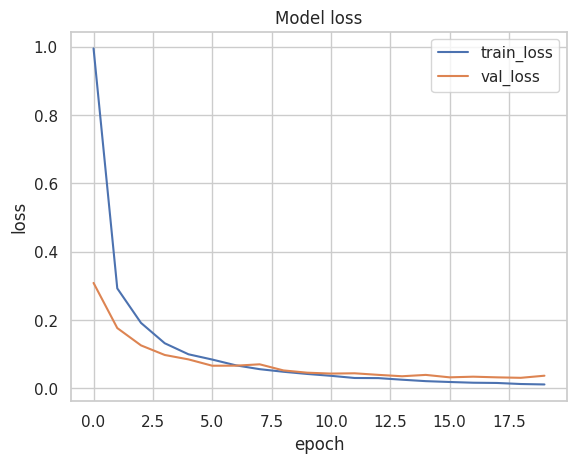

In [67]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

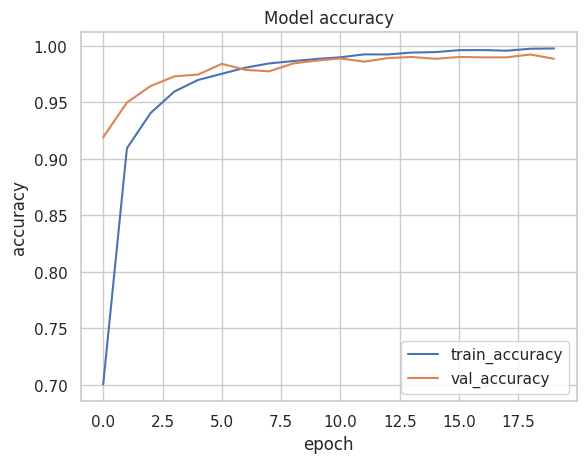

In [68]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

#Test Dataset metrics calculation

In [71]:
lenet_model.evaluate(testing_dataset)

3111/3111 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7570 - loss: 1.1899 - precision: 0.7902 - recall: 0.7236 - top_k_accuracy: 0.9187


[1.1721727848052979,
 0.7608485817909241,
 0.9222115278244019,
 0.7944055795669556,
 0.7303118109703064]

In [72]:
efficientnet_model.evaluate(testing_dataset)

3111/3111 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.9559 - loss: 0.1361 - precision: 0.9564 - recall: 0.9541 - top_k_accuracy: 0.9949


[0.13176140189170837,
 0.9585342407226562,
 0.9935712218284607,
 0.9606070518493652,
 0.9562841653823853]

In [73]:
mobilenet_model.evaluate(testing_dataset)

3111/3111 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.8619 - loss: 0.4082 - precision: 0.8795 - recall: 0.8539 - top_k_accuracy: 0.9489


[0.40347543358802795,
 0.8649951815605164,
 0.9540340900421143,
 0.8832723498344421,
 0.8537448048591614]

In [75]:
densenet_model.evaluate(testing_dataset)

3111/3111 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.9076 - loss: 0.2942 - precision: 0.9154 - recall: 0.9028 - top_k_accuracy: 0.9805


[0.2837793529033661,
 0.9141755104064941,
 0.9807136058807373,
 0.9205729365348816,
 0.9090324640274048]

In [70]:
vit_model.evaluate(testing_dataset)

3111/3111 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - accuracy: 0.9903 - loss: 0.0261 - precision: 0.9920 - recall: 0.9895


[0.025410478934645653,
 0.9916425347328186,
 0.9932323694229126,
 0.9906782507896423]

In [ ]:
# After training
pretrained_model.save("efficientB0_final.h5")

#ROC AUC

In [91]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

num_classes = 15
class_names = ["Pepper__bell___Bacterial_spot", "Pepper__bell___healthy",
                   "Potato___Early_blight","Potato___healthy","Potato___Late_blight",
                   "Tomato__Target_Spot","Tomato__Tomato_mosaic_virus","Tomato__Tomato_YellowLeaf__Curl_Virus","Tomato_Bacterial_spot",
                   "Tomato_Early_blight","Tomato_healthy","Tomato_Late_blight",
                    "Tomato_Leaf_Mold","Tomato_Septoria_leaf_spot","Tomato_Spider_mites_Two_spotted_spider_mite"] # replace with actual class names

# One-hot encode labels
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Get model predictions (probabilities)
y_score = vit_model.predict(test_dataset)  # shape: (num_samples, 21)

3111/3111 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step


In [93]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


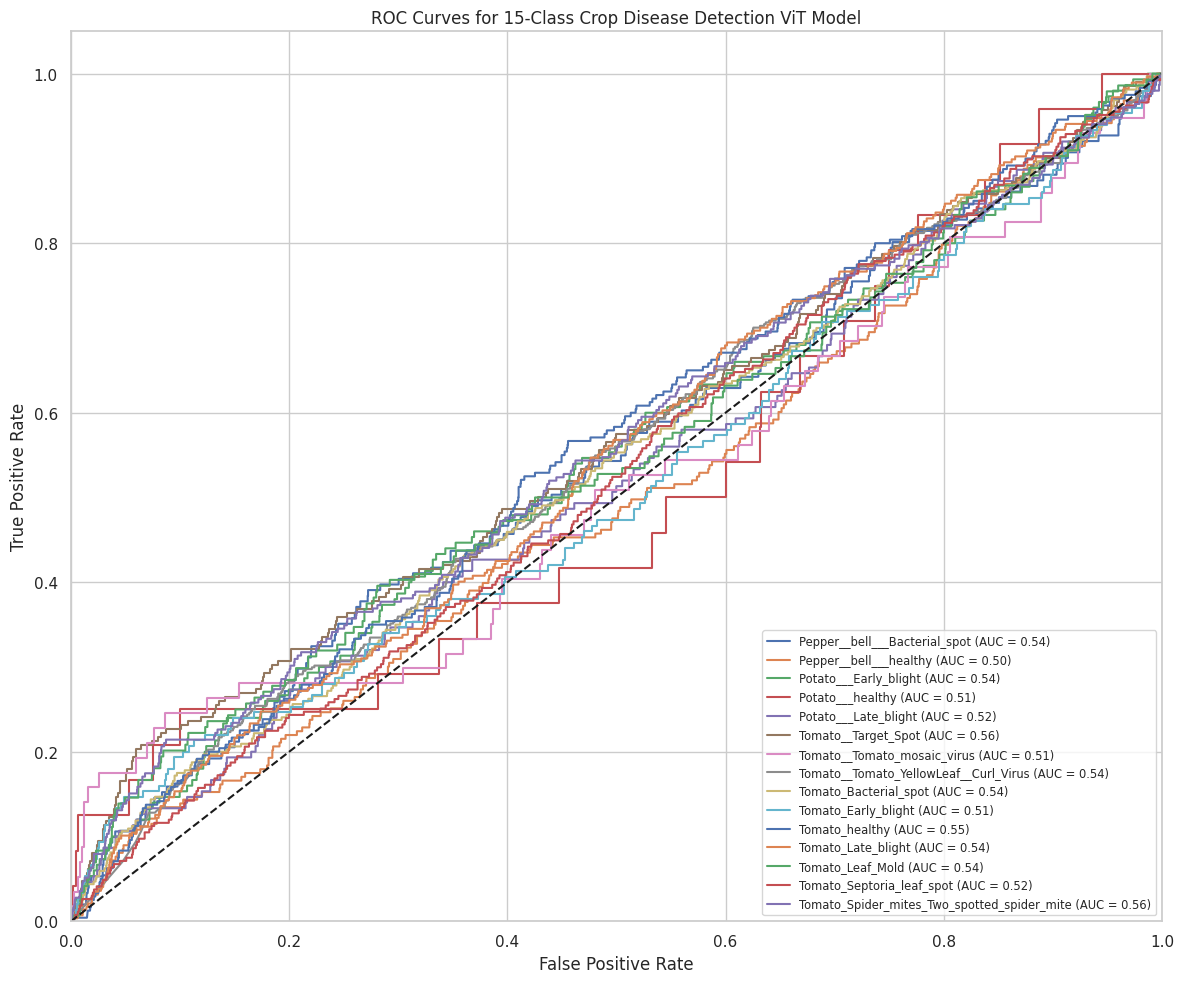

In [94]:
plt.figure(figsize=(12, 10))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for 15-Class Crop Disease Detection ViT Model")
plt.legend(loc="lower right", fontsize="x-small")
plt.grid(True)
plt.tight_layout()
plt.show()


# Testing

In [ ]:
test_image = cv2.imread("/content/drive/MyDrive/ICVDD/ICVDD_Ver2/test/Chilli_Leaf curl virus/IMG20250429160929.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(ensemble_model(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(ensemble_model(im), axis = -1).numpy()[0]])

tf.Tensor(
[[9.8034448e-08 1.5426529e-07 4.9008227e-06 7.3516719e-07 9.2999862e-08
  1.5637515e-07 4.7383881e-05 3.2959273e-05 6.9276393e-06 8.1455300e-06
  9.0670519e-02 6.1738468e-03 7.2193873e-01 1.7570075e-01 4.4784354e-04
  8.6482596e-06 3.5768060e-04 2.2992399e-06 3.5367880e-03 2.2326142e-04
  8.3803595e-04]], shape=(1, 21), dtype=float32)
Okra_Cercospora leaf spot


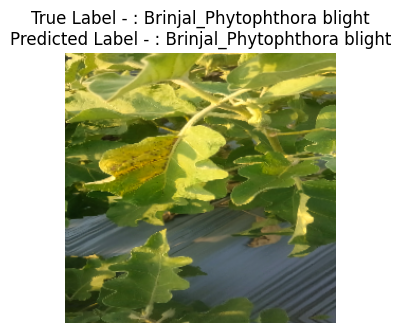

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  # Iterate up to the number of images in the batch
  num_images_to_display = min(16, images.shape[0]) # Take minimum of 16 or actual batch size
  for i in range(num_images_to_display):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    # Ensure ensemble_model is compiled before making predictions for visualization
    # (This is already done in the provided code snippet before the error section,
    # but it's good practice to be aware).
    predicted_label_index = tf.argmax(ensemble_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0]

    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CONFIGURATION["CLASS_NAMES"][int(predicted_label_index)] )
    plt.axis("off")
plt.tight_layout() # Add this for better spacing
plt.show() # Add this to display the plot

## Confusion Matrix

In [3]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(efficientnet_model(im))
  labels.append(label.numpy())

NameError: name 'validation_dataset' is not defined

In [96]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[ 7  8  1 ... 14 10  8]
[ 7  8  1 ... 11 10  8]


In [97]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[145   0   8   0   0   0   0   0   0   1   0   4   0   2   0]
 [ 41 180   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 154   0   4   0   0   0   0   0   0   2   0   0   0]
 [  0   1   0  17   2   1   0   0   0   0   0   1   0   0   0]
 [  0   0   1   0 109   2   0   0   1   0   0  37   0   0   0]
 [  3   2   0   0   0 166   0   0  16   7   0   2   0   9   5]
 [  0   0   0   0   0   0   0   1   0   0   0   7  47   0   0]
 [ 37   1   0   0   2   4   0 315  30   1   0  83   7   2  10]
 [  6   5   0   0   0   6   0   0 292   1   0   8   0   1   0]
 [  2   1   8   0   0   4   0   0   8  97   0  19   0  11   0]
 [  0   0   1   1   0 109   0   0   0   0 123   4   0   0  10]
 [  2   2   2   0   7   3   0   0   0   8   1 260   1   0   0]
 [  2   5   0   0   0   2   0   0   2   0   0  25 103   3   0]
 [ 11   0  13   0   1   4   0   0  38   4   0  25  17 162   0]
 [  1   9   0   0   0   9   0   0   0   0   0   4  10   0 228]]


Text(0.5, 54.249999999999986, 'Predicted')

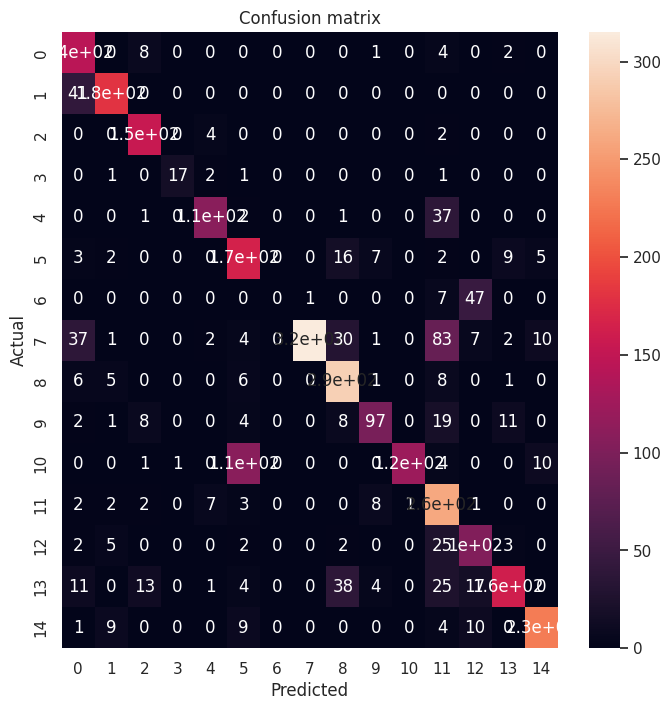

In [98]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Visualization

## Feature Map Visualization

#Step 1: Extract the CNN Submodel

In [ ]:
cnn_activation_model = Model(inputs=lenet_model.input, outputs=[layer.output for layer in lenet_model.layers if 'conv' in layer.name])



In [ ]:
img = image.load_img("/content/drive/MyDrive/ICVDD/ICVDD_Ver2/test/Brinjal_Phytophthora blight/IMG20250429172150_0_5034.jpg", target_size=(256, 256))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

feature_maps = cnn_activation_model.predict(img_array)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m139394589842896\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 256, 256, 3), dtype=float32)\n  • training=False\n  • mask=None'

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights= None,
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),

)

In [ ]:
vgg_backbone.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
test_image = cv2.imread("/content/drive/MyDrive/ICVDD/ICVDD_Ver2/test/Brinjal_Fusarium oxysporium/IMG20250429172057_0_2427.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [ ]:
print(len(f_maps))

13


In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels ))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")


## GradCam

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['normalization[0][0]']      

In [ ]:
pretrained_model.load_weights('/content/drive/MyDrive/Bang/mobilenet_human_emotions.h5')

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [ ]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

(1, 256, 256, 3)


In [ ]:
preds = pretrained_model.predict(img_array)

1/1 [==============================] - 0s 35ms/step


In [ ]:
print(preds)

[[1.1035408e-02 9.8881429e-01 1.5026570e-04]]


In [ ]:
np.argmax(preds[0])

1

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
classifier_layer_names = [
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [ ]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
print(pooled_grads.shape)

(2048,)


In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

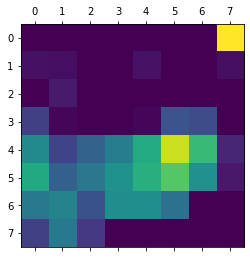

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

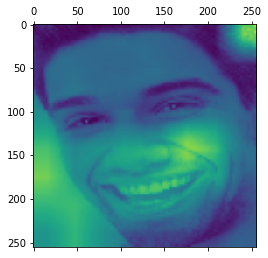

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)

# Exporting to Onnx format

In [ ]:
hf_model.save('vit_finetuned')

INFO:tensorflow:Assets written to: vit_finetuned/assets


INFO:tensorflow:Assets written to: vit_finetuned/assets


In [ ]:
hf_model.save('vit_finetuned.h5')

## Installation

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 12.6 MB/s 
     |████████████████████████████████| 13.1 MB 43.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115.3 MB 2.8 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 


In [ ]:
import onnxruntime as rt
rt.get_device()

'GPU'

## Conversion

### From TensorFlow SavedModel

In [ ]:
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_onnx.onnx

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-05-25 13:11:26,360 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-05-25 13:11:34,252 - INFO - Signatures found in model: [serving_default].
2022-05-25 13:11:34,252 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-05-25 13:11:34,253 - INFO - Output names: ['dense']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-05-25 13:11:45,495 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-05-25 13:11:50,911 - INFO - Using tenso

### From Keras Model

In [ ]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = "lenet_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model_for_export, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
print(output_names)

['dense_2']


In [ ]:
output_names = ['dense']

## Inference

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = test_image.astype(np.float32)

im = np.expand_dims(im, axis = 0)

In [ ]:
N_PREDICTIONS = 10

### Benchmarking Onnx

In [ ]:
providers=['CPUExecutionProvider' ]
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
t1 = time.time()

for _ in range(N_PREDICTIONS):
  onnx_pred = m.run(['dense'], {"input": im})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.2902926683425903


In [ ]:
print(onnx_pred)

[array([[0.00484342, 0.00301275, 0.99214387]], dtype=float32)]


### Benchmarking TF

In [ ]:
t1 = time.time()
for _ in range(N_PREDICTIONS):
  hf_model(im)
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.7937646389007569


In [ ]:
tf, gpu = 0.15s
tf, cpu = 0.8s
tf_size = 1000MB

onnx, cpu = 0.5s
onnx, gpu = 0.025s
onnx_size = 328MB

onnx_quantized, cpu = 0.4s
onnx_quantized, gpu = 0.3s
onnx_quantized_size = 83MB

In [ ]:
0.8/0.35

2.285714285714286

## Quantization with Onnx

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = '/content/eff_keras.onnx'
model_quant = '/content/eff_quantized.onnx'

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._0/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._0/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._1/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._1/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._2/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._2/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._3/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._3/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._4/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._4/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[m

### Accuracy Drop due to Quantization

In [ ]:
def accuracy(model):
  total, acc = 0,0
  for im, label in validation_dataset:
    onnx_pred = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_pred, axis = -1)[0][0]) == int(np.argmax(label, axis = -1)[0])):
      acc += 1

    total += 1
  return acc/total

In [ ]:
providers=['CUDAExecutionProvider']
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
m_q = rt.InferenceSession("/content/vit_quantized.onnx", providers=providers)
print(accuracy(m_q))
print(accuracy(m))

0.9051799824407375
0.9051799824407375


In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 27.0 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 86 kB 8.0 MB/s 


In [ ]:
import onnxruntime as rt

In [ ]:
providers=['CPUExecutionProvider' ]
m_q = rt.InferenceSession("/content/drive/MyDrive/Bang/eff_quantized.onnx", providers=providers)

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/553112.jpg"
test_image = cv2.imread(img_path)
print(test_image.shape)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = np.float32(test_image)
img_array = np.expand_dims(im, axis = 0)
print(img_array.shape)

(90, 90, 3)
(1, 256, 256, 3)


In [ ]:
onnx_pred = m_q.run(['dense'], {"input":img_array})
print(np.argmax(onnx_pred[0][0]))

fastapi==0.87.0
numpy==1.23.4
onnxruntime==1.13.1
Pillow==9.3.0

1


In [ ]:
!pip install onnxruntime==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.7 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 


# Quantization in TensorFlow

### Installation and Import

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 237 kB 4.1 MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot

## Quantization Aware Training

In [ ]:
backbone,

x = GlobalAveragePooling2D()(backbone.output)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_func_model = tf.keras.Model(inputs = backbone.input, outputs = output )

pretrained_func_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0]']      

In [ ]:
pretrained_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dense_9 (Dense)             (None, 3)                

In [ ]:
#quant_aware = tfmot.quantization.keras.quantize_model(lenet_model)

In [ ]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [ ]:
quant_aware_eff = tf.keras.models.clone_model(
    pretrained_func_model, clone_function=apply_quantization_to_conv
)

In [ ]:
quant_aware_eff.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[1][0]']            
                                                                                                  
 quantize_annotate (QuantizeAnn  (None, 257, 257, 3)  0          ['normalization[1][0]']      

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[1][0]']            
                                                                                                  
 quant_stem_conv_pad (QuantizeW  (None, 257, 257, 3)  1          ['normalization[1][0]']      

## Post Training Quantization

In [ ]:
pretrained_model.load_weights("/content/drive/MyDrive/Bang/eff_keras.h5")

In [ ]:
pretrained_model.evaluate(validation_dataset)

72/72 [==============================] - 202s 3s/step - loss: 0.6804 - accuracy: 0.8406 - top_k_accuracy: 0.9565


[0.6804420351982117, 0.8406496644020081, 0.9565408229827881]

In [ ]:
def representative_data_gen():
  for input_value,j in training_dataset.take(20):
    yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pretrained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen

In [ ]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvxl2_5_5/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/content/quantized_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"eff_model.tflite"
tflite_model_file.write_bytes(tflite_model)

22148664

In [ ]:
pretrained_model.save("eff_model.h5")

### TFLIte Runtime

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 2.2 MB 4.4 MB/s 


In [ ]:
import tflite_runtime as tflite
import numpy as np
import cv2

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/148266.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
test_image = np.expand_dims(test_image, axis = 0)

#print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

In [ ]:
interpreter = tflite.Interpreter(model_path="/content/drive/MyDrive/Bang/eff_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
# test_image = im.numpy().astype(input_details["dtype"])

interpreter.set_tensor(input_details["index"], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]


In [ ]:
print(CONFIGURATION['CLASS_NAMES'][np.argmax(output)])

happy


### Accuracy of Quantized Model

In [ ]:
def accuracy(model_path):
  total, correct = 0,0
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  for im, label in validation_dataset:

    test_image = im.numpy().astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    if(int(np.argmax(output)) == int(np.argmax(label, axis = -1)[0])):
      correct += 1

    total += 1
  return correct/total

In [ ]:
accuracy("/content/drive/MyDrive/Bang/eff_model.tflite")

0.82

In [ ]:
84%

# Pruning

In [ ]:

# Helper function uses `prune_low_magnitude` to make only the
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
  print(layer.name)
  if layer.name != "rescaling_1" and layer.name != "normalization" and layer.name != "sequential_1":

    pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                  initial_sparsity=0.2,
                  final_sparsity=0.8, begin_step=0, end_step=2000),

          }

    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    lenet_model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

sequential_1
conv2d
batch_normalization_1
max_pooling2d
dropout_37
conv2d_1
batch_normalization_2
max_pooling2d_1
flatten
dense_4
batch_normalization_3
dropout_38
dense_5
batch_normalization_4
dense_6
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 prune_low_magnitude_conv2d   (None, 254, 254, 6)      332       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_batch_n  (None, 254, 254, 6)      25        
 ormalization_1 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 127, 127, 6)  

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


 _37 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_conv2d_  (None, 125, 125, 16)     1746      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_batch_n  (None, 125, 125, 16)     65        
 ormalization_2 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 62, 62, 16)       1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_flatten  (None, 61504)            1         
  (PruneLowMagnitude)                                            
          

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

model_for_pruning = prune_low_magnitude(model_for_pruning, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

ValueError: ignored

In [ ]:
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(training_dataset,
                      validation_data = validation_dataset,
                      epochs=3,
                      callbacks=callbacks)

Epoch 1/3
213/213 [==============================] - 37s 149ms/step - loss: 0.9830 - accuracy: 0.5563 - val_loss: 1.0246 - val_accuracy: 0.5215
Epoch 2/3
213/213 [==============================] - 31s 142ms/step - loss: 0.8018 - accuracy: 0.6491 - val_loss: 1.0799 - val_accuracy: 0.5430
Epoch 3/3
213/213 [==============================] - 28s 131ms/step - loss: 0.7204 - accuracy: 0.6869 - val_loss: 1.0230 - val_accuracy: 0.5079


In [ ]:
lenet_model.save("lenet.h5")

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

#_, pruned_keras_file = tempfile.mkstemp('eff_pruned.h5')
tf.keras.models.save_model(model_for_export, "lenet_pruned_1.h5", include_optimizer=False)
#print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
hf_model.save('hf.h5')

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  with zipfile.ZipFile("lenet_keras.zip", 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return "good"#os.path.getsize(zipped_file)

In [ ]:
get_gzipped_model_size("lenet_pruned_1.h5")

'good'

#TFRecords

In [ ]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
# val_dataset = (
#     validation_dataset
#     .unbatch()
# )

In [ ]:
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
# val_dataset

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
# val_recons_dataset = tf.data.TFRecordDataset(
#     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )


In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# val_parsed_dataset = (
#     val_recons_dataset
#     .map(parse_tfrecords)
#     .batch(CONFIGURATION["BATCH_SIZE"])
#     .prefetch(tf.data.AUTOTUNE)
# )


In [ ]:
parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.41960788, 0.41960788, 0.41960788],
         [0.6       , 0.6       , 0.6       ],
         [0.07843138, 0.07843138, 0.07843138],
         ...,
         [0.6627451 , 0.6627451 , 0.6627451 ],
         [0.5019608 , 0.5019608 , 0.5019608 ],
         [0.97647065, 0.97647065, 0.97647065]],

        [[0.97647065, 0.97647065, 0.97647065],
         [0.3529412 , 0.3529412 , 0.3529412 ],
         [0.16470589, 0.16470589, 0.16470589],
         ...,
         [0.36862746, 0.36862746, 0.36862746],
         [0.6862745 , 0.6862745 , 0.6862745 ],
         [0.8117648 , 0.8117648 , 0.8117648 ]],

        [[0.4901961 , 0.4901961 , 0.4901961 ],
         [0.8745099 , 0.8745099 , 0.8745099 ],
         [0.6       , 0.6       , 0.6       ],
         ...,
         [0.25490198, 0.25490198, 0.25490198],
         [0.09019608, 0.09019608, 0.09019608],
         [0.49411768, 0.49411768, 0.49411768]],

        ...,

        [[0.70980394, 0.70980394

In [ ]:
# val_parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)


In [ ]:
history = lenet_model.fit(
    parsed_dataset,
    #validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )

Epoch 1/20
170/170 [==============================] - 24s 54ms/step - loss: 1.3162 - accuracy: 0.3846
Epoch 2/20
170/170 [==============================] - 9s 54ms/step - loss: 0.2676 - accuracy: 0.9180
Epoch 3/20
170/170 [==============================] - 9s 54ms/step - loss: 0.0477 - accuracy: 0.9915
Epoch 4/20
170/170 [==============================] - 9s 54ms/step - loss: 0.0101 - accuracy: 0.9996


KeyboardInterrupt: ignored

In [ ]:
def make_example(encoded_image, label):
    image_feature = Feature(
        bytes_list=BytesList(value=[
            encoded_image,
        ]),
    )
    label_feature = Feature(
        int64_list=Int64List(value=[
            label,
        ])
    )

    features = Features(feature={
        'image': image_feature,
        'label': label_feature,
    })

    example = Example(features=features)

    return example.SerializeToString()



In [ ]:
train_processed = (
    training_dataset
    .map(process_image)
)

In [ ]:
for i,j in train_processed.take(1):
  print(i)
  print("\n j", j)

tf.Tensor(
[[[ 37  37  37]
  [ 37  37  37]
  [162 162 162]
  ...
  [ 93  93  93]
  [140 140 140]
  [143 143 143]]

 [[180 180 180]
  [  0   0   0]
  [219 219 219]
  ...
  [ 12  12  12]
  [ 46  46  46]
  [ 63  63  63]]

 [[220 220 220]
  [253 253 253]
  [ 36  36  36]
  ...
  [ 35  35  35]
  [149 149 149]
  [ 83  83  83]]

 ...

 [[161 161 161]
  [160 160 160]
  [215 215 215]
  ...
  [106 106 106]
  [ 18  18  18]
  [ 90  90  90]]

 [[207 207 207]
  [205 205 205]
  [ 26  26  26]
  ...
  [209 209 209]
  [ 44  44  44]
  [140 140 140]]

 [[  6   6   6]
  [124 124 124]
  [250 250 250]
  ...
  [235 235 235]
  [ 70  70  70]
  [ 21  21  21]]], shape=(256, 256, 3), dtype=uint8)

 j tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
# filename = 'test.tfrecord'
# writer = tf.data.experimental.TFRecordWriter(filename)
# writer.write(serialized_features_dataset)

In [ ]:
for i,j in train_dataset.take(1):
  print(i)

tf.Tensor(
[[[[ 6.          6.          6.        ]
   [ 7.625       7.625       7.625     ]
   [ 8.6875      8.6875      8.6875    ]
   ...
   [40.9375     40.9375     40.9375    ]
   [43.         43.         43.        ]
   [43.         43.         43.        ]]

  [[ 6.8125      6.8125      6.8125    ]
   [ 7.7773438   7.7773438   7.7773438 ]
   [ 8.128906    8.128906    8.128906  ]
   ...
   [42.308594   42.308594   42.308594  ]
   [43.8125     43.8125     43.8125    ]
   [43.8125     43.8125     43.8125    ]]

  [[ 7.6875      7.6875      7.6875    ]
   [ 8.5         8.5         8.5       ]
   [ 8.214844    8.214844    8.214844  ]
   ...
   [46.535156   46.535156   46.535156  ]
   [47.308594   47.308594   47.308594  ]
   [46.75       46.75       46.75      ]]

  ...

  [[ 1.          1.          1.        ]
   [ 0.44140625  0.44140625  0.44140625]
   [ 0.3125      0.3125      0.3125    ]
   ...
   [41.839844   41.839844   41.839844  ]
   [42.3125     42.3125     42.3125    ]
   [4

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def process_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    #image = tf.io.encode_jpeg(image)
    return image, label

ds_train_encoded = (
    train_dataset
    .unbatch()
    .map(process_image)
)


In [ ]:
for i in train_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[140.      , 140.      , 140.      ],
         [140.      , 140.      , 140.      ],
         [140.      , 140.      , 140.      ],
         ...,
         [ 38.1875  ,  38.1875  ,  38.1875  ],
         [ 32.      ,  32.      ,  32.      ],
         [ 32.      ,  32.      ,  32.      ]],

        [[139.1875  , 139.1875  , 139.1875  ],
         [139.1875  , 139.1875  , 139.1875  ],
         [139.1875  , 139.1875  , 139.1875  ],
         ...,
         [ 37.32422 ,  37.32422 ,  37.32422 ],
         [ 32.660156,  32.660156,  32.660156],
         [ 32.      ,  32.      ,  32.      ]],

        [[139.      , 139.      , 139.      ],
         [139.      , 139.      , 139.      ],
         [139.      , 139.      , 139.      ],
         ...,
         [ 39.960938,  39.960938,  39.960938],
         [ 40.375   ,  40.375   ,  40.375   ],
         [ 39.5625  ,  39.5625  ,  39.5625  ]],

        ...,

        [[ 36.6875  ,  36.6875  ,

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
dataset = tf.data.TFRecordDataset(filenames = ["/content/tfrecordss/shard_00.tfrecord","/content/tfrecordss/shard_01.tfrecord"])
dataset

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["label"] = example["label"]
    return example

def prepare_sample(sample):
  return sample['image'], sample['label']

In [ ]:
def prepare_sample(sample):
  return sample['image'], sample['label']

In [ ]:
new_dataset = (
    dataset
    .map(parse_tfrecord_fn)
    .map(prepare_sample)
    .batch(32)
)